# Fáza 2 - Predspracovanie údajov

__Autori:__ Dávid Penťa, Samuel Bernát
__Percentuálny podiel práce:__ 50% / 50%

V tejto fáze sa od Vás očakáva že realizujte predspracovanie údajov pre strojové učenie. Výsledkom bude upravená dátová sada (csv alebo tsv), kde jedno pozorovanie je opísané jedným riadkom.
- scikit-learn vie len numerické dáta, takže treba niečo spraviť s nenumerickými dátami.
- Replikovateľnosť predspracovania na trénovacej a testovacej množine dát, aby ste mohli
zopakovať predspracovanie viackrát podľa Vašej potreby (iteratívne).

Keď sa predspracovaním mohol zmeniť tvar a charakteristiky dát, je možné že treba realizovať EDA opakovane podľa Vašej potreby. Bodovanie znovu (EDA) nebudeme, zmeny ale dokumentujte. Problém s dátami môžete riešiť iteratívne v každej fáze aj vo všetkých fázach podľa potreby.

In [105]:
import statsmodels.api as sm
import dateparser as dateparser
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.stats.api as sms
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import pearsonr
import math
from matplotlib import pyplot
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from operator import itemgetter
from sklearn.impute import KNNImputer
import copy
from sklearn.model_selection import train_test_split

In [98]:
measurements_file = "data/measurements.csv"
measurements_data = pd.read_csv(measurements_file, sep='\t')
measurements_data_med = pd.read_csv(measurements_file, sep='\t')
measurements_data_avg = pd.read_csv(measurements_file, sep='\t')
measurements_data_knn = pd.read_csv(measurements_file, sep='\t')

stations_file = "data/stations.csv"
stations_data = pd.read_csv(stations_file, sep='\t')

In [99]:
column_names_measurements = []
column_names_stations = []
column_names = []

for column_name in list(stations_data.columns.values):
    column_names_stations.append(column_name)
    column_names.append(column_name)

for column_name in list(measurements_data.columns.values):
    column_names_measurements.append(column_name)
    column_names.append(column_name)

chemicals = copy.deepcopy(column_names_measurements)

for i in ['warning', 'latitude', 'longitude']:
    chemicals.remove(i)

chemicals

['PM10',
 'CO',
 'Pb',
 'C2H3NO5',
 'CFCs',
 'H2CO',
 'O3',
 'TEMP',
 'NOx',
 'SO2',
 'NH3',
 'CH4',
 'PRES',
 'PM2.5',
 'PAHs']

## Integrácia a čistenie dát
Transformujte dáta na vhodný formát pre strojové učenie t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte.
- Pri riešení chýbajúcich hodnôt (missing values) vyskúšajte rôzne stratégie ako napr.
    - odstránenie pozorovaní s chýbajúcimi údajmi
    - nahradenie chýbajúcej hodnoty mediánom, priemerom, pomerom (ku korelovanému atribútu), alebo pomocou lineárnej regresie resp. kNN
- Podobne postupujte aj pri riešení vychýlených hodnôt (outlier detection):
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% resp. 95%)

### 1. Chýbajúce hodnoty
Prvou použitou technikou odstránim pozorovania s chýbajúcimi údajmi (v tvare Nan).

In [462]:
measurements_data.dropna(inplace=True)
stations_data.dropna(inplace=True)

stations_data["QoS"] = np.where(stations_data["QoS"] == "accep", "acceptable", stations_data["QoS"])
stations_data["QoS"] = np.where(stations_data["QoS"] == "maitennce", "maintenance", stations_data["QoS"])

stations_data['revision'] = stations_data['revision'].apply(lambda x: pd.Timestamp(x).timestamp())

stations_data['latitude'] = stations_data['latitude'].round(5)
stations_data['longitude'] = stations_data['longitude'].round(5)

stations_data["station"] = np.where(stations_data["station"] == "T‚Äôaebaek", "Taebaek", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "'Ali Sabieh", "Ali Sabieh", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Oktyabr‚Äôskiy", "Oktyabrsk", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Roslavl‚Äô", "Roslavl", stations_data["station"])
stations_data["station"] = np.where(stations_data["station"] == "Dyat‚Äôkovo", "Dyatkovo", stations_data["station"])

measurements_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12068 entries, 0 to 12067
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PM10       12019 non-null  float64
 1   CO         12019 non-null  float64
 2   Pb         12019 non-null  float64
 3   C2H3NO5    12019 non-null  float64
 4   CFCs       12019 non-null  float64
 5   H2CO       12018 non-null  float64
 6   O3         12020 non-null  float64
 7   TEMP       12020 non-null  float64
 8   NOx        12018 non-null  float64
 9   SO2        12020 non-null  float64
 10  latitude   12068 non-null  float64
 11  longitude  12068 non-null  float64
 12  NH3        12018 non-null  float64
 13  CH4        12018 non-null  float64
 14  PRES       12068 non-null  float64
 15  PM2.5      12020 non-null  float64
 16  warning    12018 non-null  float64
 17  PAHs       12020 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


Druhou technikou nahradím v datasete chýbajúce hodnoty mediánom daného stĺpca.

In [463]:
for col in measurements_data_med:
    measurements_data_med[col].fillna((measurements_data[col].median()), inplace=True)

Treťou technikou nahradím v datasete chýbajúce hodnoty priemerom daného stĺpca.

In [464]:
for col in measurements_data_avg:
    measurements_data_avg[col].fillna((measurements_data[col].mean()), inplace=True)

Poslednou technikou nahradím v datasete chýbajúce hodnoty hodnotou vypočítanou metódou kNN, s nastavením na 5 susedov.

In [465]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(measurements_data_knn)

measurements_data_knn = pd.DataFrame(imputer.transform(measurements_data_knn), columns=column_names_measurements).copy()

In [466]:
# display(measurements_data_med.describe())
# display(measurements_data_avg.describe())
# display(measurements_data_knn.describe())
# measurements_data_med.shape

### 2. Outlier detection
Použitím prvej techniky odstránim vychýlené pozorovania z datasetu, použitím druhej techniky nahradím vychýlené hodnoty hraničnými hodnotami rozdelenia v pomere 5% a 95%. Dataset measurements_data_out_drop reprezentuje použitie techniky odstránenia hraničných hodnôt, measurements_data_out reprezentuje nahradenie daných hodnôt.

In [103]:
measurements_data_out = measurements_data.copy(deep=True)
measurements_data_out_drop = measurements_data.copy(deep=True)
#print("Old: ", measurements_data_out.shape)

def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return a[(a > upper) | (a < lower)]

def get5_95(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)

    return [lower, upper]


measurements_outliers = {}
measurements_5_95 = {}

for column in chemicals:
    measurements_outliers[column] = identify_outliers(measurements_data_out[column])
    measurements_5_95[column] = get5_95(measurements_data_out[column])

outliers = pd.DataFrame(data=measurements_outliers)

# drop
measurements_data_out_drop = measurements_data_out_drop.drop(outliers.index)

# nahradenie hraničnými hodnotami (5% / 95%)?
for column in chemicals:
    for u in outliers[column].loc[~outliers[column].isnull()]:
        if u <= measurements_5_95[column][0]:
            u = measurements_5_95[column][0]
        else:
            u = measurements_5_95[column][1]

new_column_names=['latitude', 'longitude', 'warning']
outliers = pd.DataFrame(outliers, columns=column_names_measurements)

outliers = outliers.fillna(measurements_data_out)


measurements_data_out.loc[outliers.index] = np.nan
measurements_data_out = measurements_data_out.combine_first(outliers)

#print("New: ", measurements_data_out_drop.shape)

In [426]:
stations_data = stations_data.groupby(by='station').apply(lambda x: x.loc[x['revision']==x['revision'].max()])

## Spojenie tabuliek

In [427]:
df=pd.merge(stations_data, measurements_data, on=['latitude', 'longitude'], how='inner')

df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,O3,TEMP,NOx,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs
0,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.94040,8.15390,51.70980,1.07014,...,7.59161,6.60825,7.42432,8.52814,10.37150,8.04118,1113.51031,8.45419,0.0,7.47770
1,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,9.92679,7.48092,50.20703,2.64911,...,7.63081,6.16413,8.41506,8.10514,8.64142,5.75635,1141.89103,8.98874,0.0,5.31318
2,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,7.70897,7.94669,30.48851,0.46590,...,9.90479,7.45631,6.88163,8.67120,7.16353,8.02152,1141.32144,8.99272,0.0,5.60567
3,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.79345,7.95665,41.96855,0.91801,...,7.43302,11.97880,9.63301,8.68320,8.31095,8.63908,1051.38525,10.07743,0.0,6.80804
4,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.19808,7.87163,25.72025,0.59423,...,5.30181,2.99136,8.13061,9.95595,5.97990,6.37283,1153.65647,9.25494,0.0,7.14369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.89369,7.75732,43.95104,1.05577,...,7.89935,13.31804,7.97301,6.95242,9.15684,6.94692,1096.63218,7.71518,1.0,9.12317
12064,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,7.15250,6.64782,56.67238,0.26810,...,5.92714,2.83320,8.14658,5.88350,4.17718,6.40035,1181.06702,10.33065,0.0,8.77173
12065,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.65674,5.70363,61.58862,0.78845,...,9.56202,4.47710,6.67552,8.31503,9.23302,7.91515,1077.81115,9.00477,0.0,8.22518
12066,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,6.27031,4.97595,49.20954,0.25750,...,6.13673,3.79766,8.25153,9.35591,4.62164,6.27290,1081.73222,9.73974,1.0,9.26331


### Opis každého atribútu numerickým formátom

In [428]:
df['QoS_ID'] = -1

df.loc[df.QoS == "excellent", "QoS_ID"] = "1"
df.loc[df.QoS == "good", "QoS_ID"] = "2"
df.loc[df.QoS == "average", "QoS_ID"] = "3"
df.loc[df.QoS == "acceptable", "QoS_ID"] = "4"
df.loc[df.QoS == "building", "QoS_ID"] = "5"
df.loc[df.QoS == "maintenance", "QoS_ID"] = "5"

df[['QoS_ID']] = df[['QoS_ID']].apply(pd.to_numeric)

In [429]:
df['station_ID'] = df['station'].rank(method='dense')
df['code_ID'] = df['code'].rank(method='dense')

df

,QoS,station,code,latitude,longitude,revision,PM10,CO,Pb,C2H3NO5,...,SO2,NH3,CH4,PRES,PM2.5,warning,PAHs,QoS_ID,station_ID,code_ID
0,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.94040,8.15390,51.70980,1.07014,...,8.52814,10.37150,8.04118,1113.51031,8.45419,0.0,7.47770,5,1.0,38.0
1,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,9.92679,7.48092,50.20703,2.64911,...,8.10514,8.64142,5.75635,1141.89103,8.98874,0.0,5.31318,5,1.0,38.0
2,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,7.70897,7.94669,30.48851,0.46590,...,8.67120,7.16353,8.02152,1141.32144,8.99272,0.0,5.60567,5,1.0,38.0
3,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.79345,7.95665,41.96855,0.91801,...,8.68320,8.31095,8.63908,1051.38525,10.07743,0.0,6.80804,5,1.0,38.0
4,maintenance,Aberdeen,GB,57.14369,-2.09814,1.545523e+09,8.19808,7.87163,25.72025,0.59423,...,9.95595,5.97990,6.37283,1153.65647,9.25494,0.0,7.14369,5,1.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12063,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.89369,7.75732,43.95104,1.05577,...,6.95242,9.15684,6.94692,1096.63218,7.71518,1.0,9.12317,1,662.0,1.0
12064,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,7.15250,6.64782,56.67238,0.26810,...,5.88350,4.17718,6.40035,1181.06702,10.33065,0.0,8.77173,1,662.0,1.0
12065,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,8.65674,5.70363,61.58862,0.78845,...,8.31503,9.23302,7.91515,1077.81115,9.00477,0.0,8.22518,1,662.0,1.0
12066,excellent,les Escaldes,AD,42.50729,1.53414,1.418947e+09,6.27031,4.97595,49.20954,0.25750,...,9.35591,4.62164,6.27290,1081.73222,9.73974,1.0,9.26331,1,662.0,1.0


### Uloženie upravenej dátovej sady do .csv súboru

In [430]:
output = df[['station_ID', 'code_ID', 'QoS_ID', 'warning', 'latitude', 'longitude', 'revision','PAHs', 'PM10', 'CO', 'Pb', 'C2H3NO5', 'CFCs', 'H2CO', 'O3', 'TEMP', 'NOx', 'SO2', 'NH3', 'CH4', 'PRES', 'PM2.5']]

output.to_csv('output.csv', index=False)

### Power Transformer

In [431]:
def transform(column_name):

    sns.histplot(data=df, hue='warning', x=column_name, fill=True, kde=True)
    plt.show()

    data = df[column_name].values
    data = data.reshape((len(data),1))

    power = PowerTransformer(
                method='yeo-johnson',
                standardize=True)
    data_trans = power.fit_transform(data)
    df[column_name] = data_trans

    sns.histplot(data=df, hue='warning', x=column_name, fill=True, kde=True)
    plt.show()

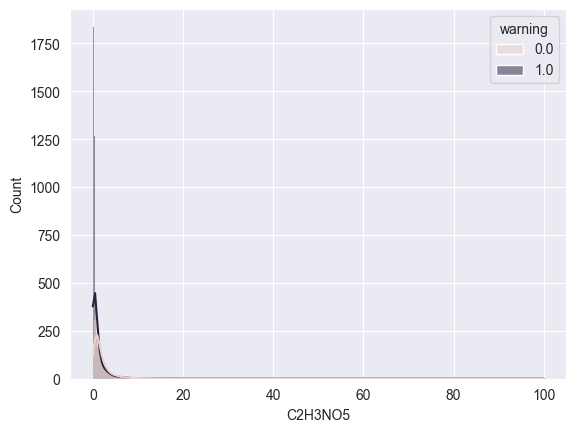

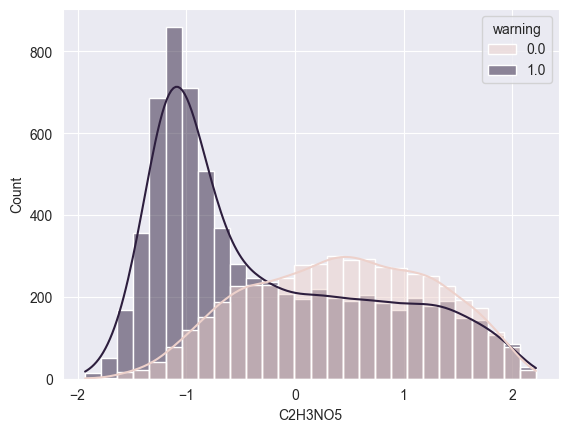

In [432]:
transform('C2H3NO5')

# arr_0 = ['PAHs', 'PM10', 'CO', 'Pb', 'C2H3NO5', 'CFCs', 'H2CO', 'O3', 'TEMP', 'NOx', 'SO2', 'NH3', 'CH4', 'PRES', 'PM2.5']
# for i in arr_0:
#     print(i)
#     transform(i)

### Zoradenie podla p a zaroven r

In [433]:
arr = []
#
for i in list(df.columns.values):
    if i != 'QoS' and i != 'station' and i != 'code':
        (r, p) = pearsonr(df['warning'], df[i])
        if p < 0.05 and i != 'warning':
            arr.append([i, abs(r), p])

arr = sorted(arr, key=itemgetter(1))
a = []
for i in range(len(arr)):
    a.append([i + 1, arr[len(arr) - i - 1][0], arr[len(arr) - i - 1][1], arr[len(arr) - i - 1][2]])

for row in a:
    print("{: >0} {: >10} {:.5f} {:.5f}".format(*row))

ValueError: array must not contain infs or NaNs

## Realizácia predspracovania dát
- Transformované dáta pre strojové učenie si rozdeľuje na trénovaciu a testovaciu množinu podľa vami preddefinovaným pomerom. Naďalej pracujte len s trénovacím datasetom.
- Transformujte atribútov dát pre strojové učenie podľa dostupných techník (minimálne 2 techniky) ako scaling, transformers a ďalšie.
- Zdôvodnite Vašu voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

V prvom rade si transformované dáta rozdelíme na testovaciu a trénovaciu množinu. Rozhodli sme sa pre pomer častí 0.7 pre časť dát na učenie a 0.3 pre dáta na testovanie. Vďaka tomuto pomeru je časť na učenie dostatočne veľká pre uspokojivé výsledky, zároveň časť na testovanie nie je zanedbateľná.


In [109]:
training_data, testing_data = train_test_split(measurements_data_out_drop, test_size=0.3, random_state=25)

print("Pocet vzoriek na trenovanie: ", training_data.shape[0])
print("Pocet vzoriek na testovanie: ", testing_data.shape[0])

Pocet vzoriek na trenovanie:  8447
Pocet vzoriek na testovanie:  3621


V rámci transformácie dát pre strojové učenie sme už v predošlých krokoch pomocou metódy škálovania, konkrétne normalizácie dát odstránili záznamy s hodnotami Nan, dáta sme dávali do rovnakého formátu a tvaru a opravovali nekorektne (nejednotne) zapísané dáta v datasetoch. Na grafoch kde sme porovnávali výsledky a správanie sa dát po odstránení záznamov s chýbajúcimi údajmi, nahradenie chýbajúcich údajov mediánom, priemerom a metódou kNN sme dospeli k záveru, že najvýhodnejší a zároveň najkorektnejší spôsob je jednoducho odstránenie záznamov, pretože sa nejednalo o veľkú vzorku v rámci našich datasetov ako celkov. Zároveň sme nenumerické hodnoty zmenili pomocou nami vymysleného kLúča na numerické - napríklad pre sĺpec Qos v datasete sme pre každý zo stavov priradili číslo od 1 do 5.